# Poly Fitting

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.special as special
import scipy.integrate as integrate
from scipy.optimize import curve_fit
import math
from symfit import parameters, variables, Fit, Model
import sympy as sp
sns.set()
%matplotlib inline

In [2]:
def fourier(t, func):
    freq = np.arange(-1/(abs(t[0])-abs(t[1]))/2, 1/(abs(t[0])-abs(t[1]))/2 , 1/(t[-1]-t[0]))
    ft = np.fft.fft(func)
    ftshift = np.fft.fftshift(ft)
    return np.array([freq, ft, ftshift])

def Efield(t, E0 = 1, w=2*np.pi*0.8, s = 0.4 , phi = 0 ):
    return E0*np.sin(w*t+phi)*np.exp(-0.5*(t)**2/s**2)# sin*gaussian

In [3]:
def phase_sweep(phi_range, sweep_pts, freq, fft, current, t):
    
    phi_0 = -phi_range/2
    amp = np.abs(fft)
    phase = []
    I = []
    I_integral = []
    sig_array = []
    sig_integral = []
    
    
    for i in range(0,sweep_pts): # *****Check to see if this will mess up length stuff

        phi = np.zeros(len(freq))       # re-initialize phi matrix
        

        for j in range(0, len(freq)):      # fill array with values
            if j >= int(len(freq)/2):
                phi[j] = phi_0
            else:
                phi[j] = -phi_0
        
        pulse = np.fft.ifft(amp*np.exp(1j*phi)) # get pulse back with new phase
        signal = []
         
        for k in range(int(len(freq)/2),int(len(freq))):  # manually shift ifft
            signal.append(pulse[k])

        for l in range(int(len(freq)/2)):
            signal.append(pulse[l])
        
        

        phase.append(phi_0)             # store phase values
        signal = np.asarray(signal)
        I_integral.append(integrate.simps(x=t, y=current.calculate(signal))) # compute I(t) integral
        I.append(current.calculate(signal))
        sig_array.append(signal)
        sig_integral.append(integrate.simps(x=t, y=signal))
        phi_0 += phi_range/sweep_pts     # compute new phi for next loop
        
            
        
        #plt.plot(t, signal)            # Plot envelope of signals

    phase = np.asarray(phase)
    I_integral = np.asarray(I_integral)
    I = np.asarray(I)
    sig_array = np.asarray(sig_array)
    
    return [phase, I_integral, sig_array, I, sig_integral]



In [4]:
## Generate current class ##

class current():
    
    # initialize current types and variables # 
    
    def __init__(self, height1=1, squeeze1=1, pos1=0, height2=1, squeeze2=1, pos2=0, shift=0,  
                 erf=False, ohm=False, cubic=False, exp=False, double_erf=False, step=False):
        self.height1 = height1
        self.squeeze1 = squeeze1
        self.pos1 = pos1
        self.height2 = height2
        self.squeeze2 = squeeze2
        self.pos2 = pos2
        self.shift = shift
        
        self.erf = erf
        self.ohm = ohm
        self.cubic = cubic
        self.exp = exp
        self.double_erf = double_erf
        self.step = step
        
    # Call calculate to generate I[V(t)] #  
        
    def calculate(self, V):
        if self.erf == True:
            calculate = self.height1*special.erf((V - self.pos1)*self.squeeze1) + self.shift
        if self.double_erf == True:
            calculate = self.height1*special.erf((V-self.pos1)*self.squeeze1) + self.height2*special.erf((V - self.pos2)*self.squeeze2) + self.shift
        if self.cubic == True:
            calculate = self.height1*(V*self.squeeze1 - self.pos1)**3 + self.height2*(V*self.squeeze2 - self.pos2) + self.shift
        if self.step == True:
            calculate = self.height1 * (V > self.pos1)
        if self.ohm == True:
            calculate = (V - self.pos1)/self.height1 + self.shift
        if self.exp == True:
            calculate = self.height1*np.exp(-(V*self.squeeze1 - self.pos1)) + self.shift
        else:
            pass
        
        return calculate

In [5]:
def amplitude_sweep(t, current, num_pts, maxE0, phi_range, phase_pts, minE0=0 ):
 
    E0 = np.linspace(minE0,maxE0,num_pts) # create array of sweep parameters
    I_integral = []  # make empty list
    ft = fourier(t, func = Efield(t,w = 2*np.pi*0.8, s = 0.4, E0=1)) # FFT
    sweep = phase_sweep(phi_range = phi_range, sweep_pts = phase_pts , freq = ft[0], fft = ft[1], current = I , t = t) # Sweep phase and create signal

    for i in range(0,num_pts):
        I_integral.append(integrate.simps(x=t, y=current.calculate(E0[i]*sweep[2]))) # calculate the integral and store it into the empty list
    
    I_integral = np.asarray(I_integral) #turn list into numpy array
    return np.array([sweep, E0, I_integral])

0.9487075758733078


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


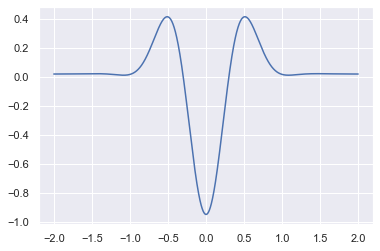

In [6]:
t = np.linspace(-2,2,2002)
I = current(height1 = 1, pos1 = 1, pos2 = -1.5, shift = 0, squeeze1 = 10,squeeze2 = 10, double_erf = True)
ft = fourier(t, func = Efield(t,w = 2*np.pi*0.8, s = 0.4,))
test = phase_sweep(phi_range=2*np.pi, sweep_pts=200, freq=ft[0], fft=ft[1], current=I, t=t)
plt.plot(t,test[2][0])
print(max(abs(test[2][0])))

C:\ProgramData\Anaconda3\lib\site-packages\numpy\ma\core.py:2795: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The following kwargs were not used by contour: 'label'
  


Text(0, 0.5, 'Amplitude')

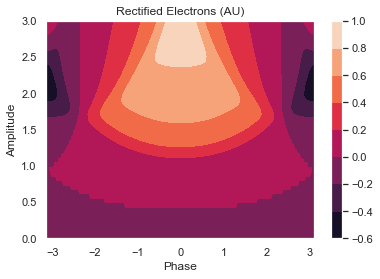

In [7]:
I = current(height1 = 1, pos1 = 1, pos2 = -1.5, shift = 0, squeeze1 = 10,squeeze2 = 10, double_erf = True)
t = np.linspace(-2,2,2002)
pts = 50
amp_sweep = amplitude_sweep(t=t,current=I, phi_range = 2*np.pi, phase_pts = 200, maxE0 = 3, num_pts = 50)
fig, ax1 = plt.subplots()
cep = ax1.contourf(amp_sweep[0][0], amp_sweep[1], amp_sweep[2], label="Q")
fig.colorbar(cep) 
ax1.set_title('Rectified Electrons (AU)')
ax1.set_xlabel('Phase')
ax1.set_ylabel('Amplitude')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\

200


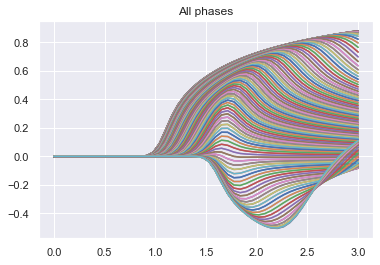

In [8]:
l=0
for i in range(0,len(amp_sweep[2][0])):
    plt.plot(amp_sweep[1], amp_sweep[2][:,i])
    l += 1
plt.title("All phases")
print(l)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


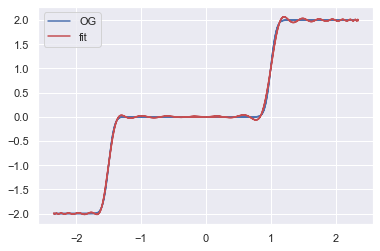

In [9]:
## Polyfitting I-V Curve ##

V = Efield(t,E0=3)
plt.plot(V,I.calculate(V), 'b', label = 'OG')
fit = np.polyfit(V,I.calculate(V), deg = 70)
f = np.poly1d(fit)
plt.plot(V,f(V), 'r', label = 'fit')
plt.legend()


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\

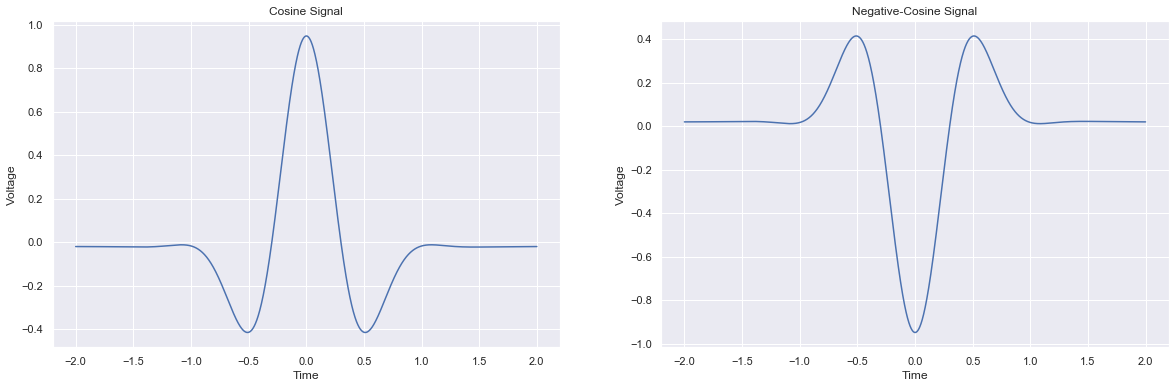

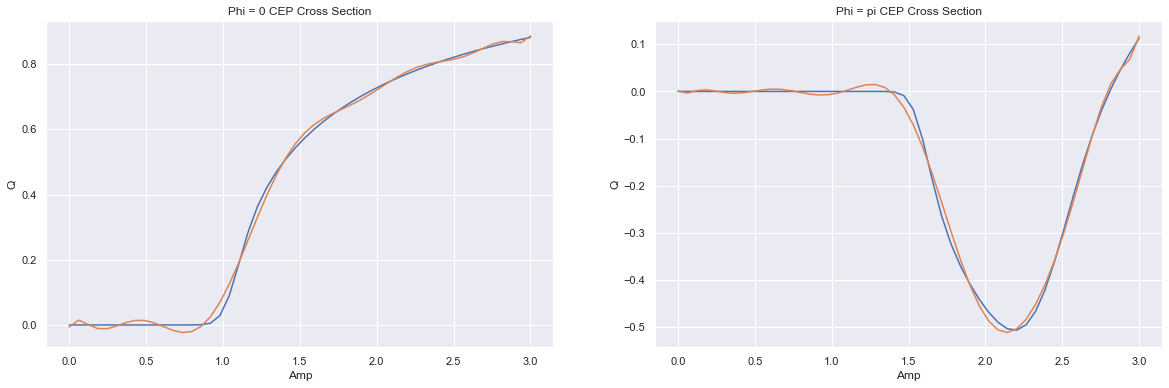

In [10]:
fit1 = np.polyfit(amp_sweep[1],amp_sweep[2][:,0], deg =12)
fit2 = np.polyfit(amp_sweep[1],amp_sweep[2][:,100], deg =12)
f1 = np.poly1d(fit1)
f2 = np.poly1d(fit2)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (20,6))
fig, (ax3,ax4) = plt.subplots(1, 2, figsize = (20,6))

ax1.plot(t, amp_sweep[0][2][100,:])
ax1.set_title("Cosine Signal")
ax1.set_xlabel("Time")
ax1.set_ylabel("Voltage")

ax2.plot(t, amp_sweep[0][2][0,:])
ax2.set_title("Negative-Cosine Signal")
ax2.set_xlabel("Time")
ax2.set_ylabel("Voltage")

ax3.plot(amp_sweep[1], amp_sweep[2][:,100])
ax3.set_title("Phi = 0 CEP Cross Section")
ax3.set_xlabel("Amp")
ax3.set_ylabel("Q")
ax3.plot(amp_sweep[1],f2(amp_sweep[1]))

ax4.plot(amp_sweep[1], amp_sweep[2][:,0])
ax4.set_title("Phi = pi CEP Cross Section")
ax4.set_xlabel("Amp")
ax4.set_ylabel("Q")
ax4.plot(amp_sweep[1],f1(amp_sweep[1]))

## Even/Odd Fitting

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


[ 8.57350329e-02+1.72281203e-17j -1.43209340e+00-3.06534935e-16j
  1.02256904e+01+2.39614293e-15j -4.05183773e+01-1.08157644e-14j
  9.64210581e+01+3.11437695e-14j -1.38024441e+02-5.95918171e-14j
  1.08892558e+02+7.64647841e-14j -2.98651054e+01-6.47972953e-14j
 -1.77621294e+01+3.48178792e-14j  1.57130259e+01-1.10058574e-14j
 -4.02190905e+00+1.78354394e-15j  3.28934929e-01-1.09545210e-16j
 -2.68255518e-03+6.08824715e-19j]


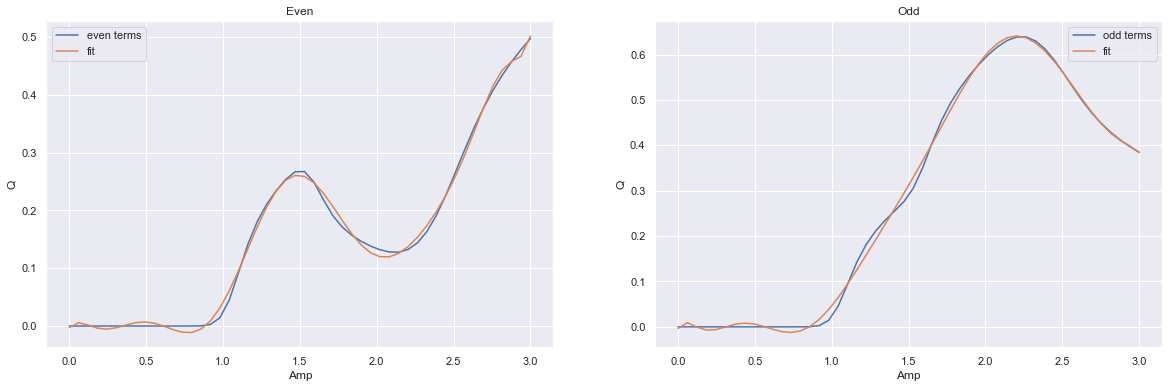

In [11]:
even_fit = (amp_sweep[2][:,100]+amp_sweep[2][:,0])/2
odd_fit = (amp_sweep[2][:,100]-amp_sweep[2][:,0])/2

fit1 = np.polyfit(amp_sweep[1], even_fit, deg =12)
fit2 = np.polyfit(amp_sweep[1], odd_fit, deg =12)
f1 = np.poly1d(fit1)
f2 = np.poly1d(fit2)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (20,6))

ax1.plot(amp_sweep[1], even_fit, label = "even terms")
ax1.set_title("Even")
ax1.set_xlabel("Amp")
ax1.set_ylabel("Q")
ax1.plot(amp_sweep[1],f1(amp_sweep[1]), label = "fit")
ax1.legend()

ax2.plot(amp_sweep[1],odd_fit, label = "odd terms")
ax2.set_title("Odd")
ax2.set_xlabel("Amp")
ax2.set_ylabel("Q")
ax2.plot(amp_sweep[1],f2(amp_sweep[1]), label = "fit")
ax2.legend()

print(fit1)

In [12]:
## Failed Attempt ##

a_n = []
V_n = []
rec_current = []
V = amp_sweep[0][2][100,:]/2.7982
A0 = np.linspace(0,6,2002)

for i in range(2,len(fit1),2):
    a_n.append(fit1[i]/integrate.simps(V**i,x=t))

for i in range(1,len(fit1),2):
    a_n.append(fit2[i]/integrate.simps(V**i,x=t))


a_n = np.asarray(a_n)

for i in range(2,len(fit1)-1):
    V_n.append(V**i)
    rec_current.append(V_n[:][i-2]*a_n[i])
    

V_n = np.asarray(V_n)

rec_current = np.asarray(current)
I_rec = np.sum(current, axis = 0) 
#plt.plot(V,I_rec)

In [13]:
# A_28=1,A_30=1,A_32=1
# +A_28*V**28+A_30*V**30+A_32*V**32
# ,A_29=1,A_31=1,A_33=1
# +A_29*V**29+A_31*V**31+A_33*V**33

In [14]:
def even(V,A_2=1,A_4=1,A_6=1,A_8=1,A_10=1,A_12=1,A_14=1,A_16=1,A_18=1,A_20=1,A_22=1):
    return A_2*V**2+A_4*V**4+A_6*V**6+A_8*V**8+A_10*V**10+A_12*V**12+A_14*V**14+A_16*V**16+A_18*V**18+A_20*V**20+A_22*V**22



def odd(V,A_3=1,A_5=1,A_7=1,A_9=1,A_11=1,A_13=1,A_15=1,A_17=1,A_19=1,A_21=1,A_23=1):
    return A_3*V**3+A_5*V**5+A_7*V**7+A_9*V**9+A_11*V**11+A_13*V**13+A_15*V**15+A_17*V**17+A_19*V**19+A_21*V**21+A_23*V**23


In [15]:
def arb_odd_poly(x, *params):
    return sum([p*(x**(2*i+1)) for i, p in enumerate(params)])

def arb_even_poly(x, *params):
    return sum([p*(x**(2*i)) for i, p in enumerate(params)])

In [16]:
V = np.linspace(0,6,len(amp_sweep[2][:,100]))
even_terms = (amp_sweep[2][:,100]+amp_sweep[2][:,0])/2
#even_terms

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


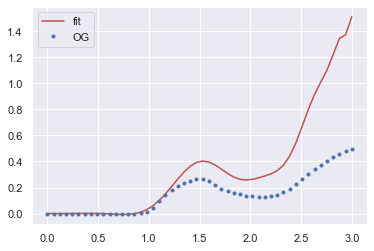

In [17]:
even_terms = (amp_sweep[2][:,100]+amp_sweep[2][:,0])/2
xdata = np.linspace(0,3,len(even_terms))

popt1, pcov1 = curve_fit(arb_even_poly, xdata, np.real(even_terms), p0=[1]*(12+1))



plt.plot(amp_sweep[1], arb_odd_poly(amp_sweep[1], *popt1), 'r-', label="fit")
plt.plot(amp_sweep[1], even_terms, 'b.', label='OG')
plt.legend()


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


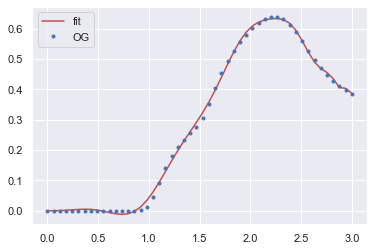

In [18]:
odd_terms = (amp_sweep[2][:,100]-amp_sweep[2][:,0])/2
xdata = np.linspace(0,3,len(odd_terms))



popt2, pcov2 = curve_fit(arb_odd_poly, xdata, np.real(odd_terms), p0=[1]*(12+1))



plt.plot(amp_sweep[1], arb_odd_poly(amp_sweep[1], *popt2), 'r-', label="fit")
plt.plot(amp_sweep[1], odd_terms, 'b.', label='OG')
plt.legend()





In [19]:
len(popt2)

13

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


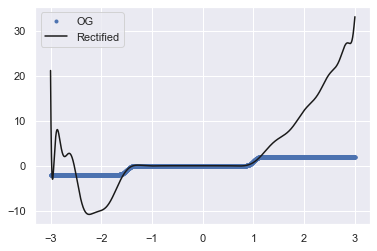

In [20]:
a_n = []
rec_current = []

V_thz = amp_sweep[0][2][100,:]/max(np.real(amp_sweep[0][2][100,:]))
A0 = np.linspace(-3,3,2002)
t=np.linspace(-2,2,2002)

for i in range(0,len(popt1)):
    a_n.append(popt1[i]/integrate.simps(V_thz**(2*i+2),x=t)) 
    a_n.append(popt2[i]/integrate.simps(V_thz**(2*i+3),x=t))

a_n = np.asarray(a_n)

for i in range(0,len(a_n)):
    rec_current.append(a_n[i]*A0**(i+2))
    

rec_I = np.sum(rec_current, axis = 0) 

plt.plot(A0, I.calculate(A0), 'b.', label="OG")
plt.plot(A0,rec_I, 'k-', label = "Rectified")
plt.legend()



## Different I-V Curves

C:\ProgramData\Anaconda3\lib\site-packages\numpy\ma\core.py:2795: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


Text(0, 0.5, 'Amplitude')

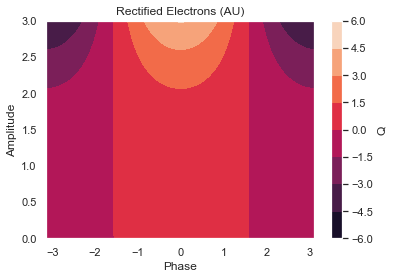

In [21]:
## Cubic ##
I = current(height1 = 1, pos1 = 0, shift = 0, squeeze1 = 1, squeeze2 = 0, height2 = 0, cubic = True)
t = np.linspace(-2,2,2002)
pts = 50
amp_sweep = amplitude_sweep(t=t,current=I, phi_range = 2*np.pi, phase_pts = 200, maxE0 = 3, num_pts = 50)
fig, ax1 = plt.subplots()
cep = ax1.contourf(amp_sweep[0][0], amp_sweep[1], amp_sweep[2])
fig.colorbar(cep, label = 'Q') 
ax1.set_title('Rectified Electrons (AU)')
ax1.set_xlabel('Phase')
ax1.set_ylabel('Amplitude')

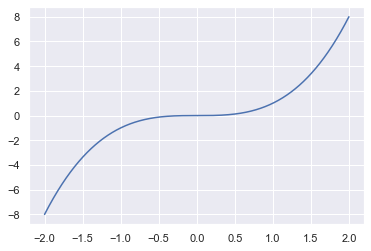

In [22]:
plt.plot(t,I.calculate(t))

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Q')

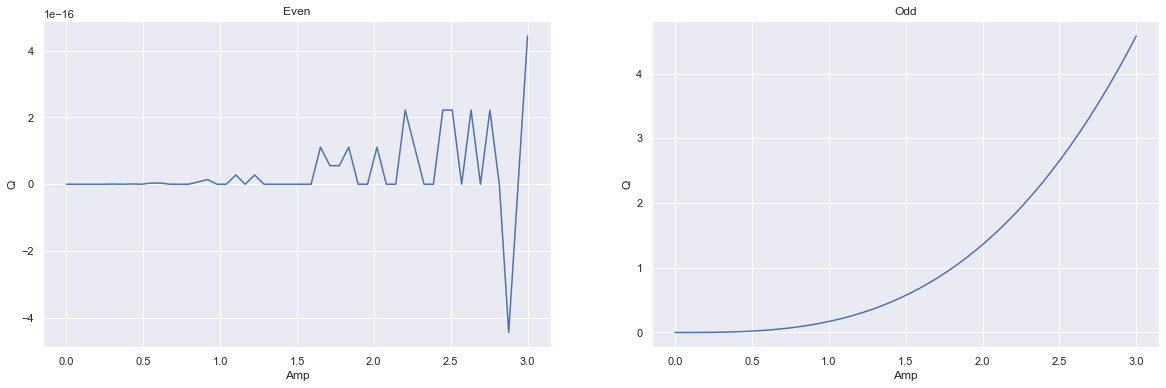

In [23]:
even_fit = (amp_sweep[2][:,100]+amp_sweep[2][:,0])/2
odd_fit = (amp_sweep[2][:,100]-amp_sweep[2][:,0])/2

fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (20,6))

ax1.plot(amp_sweep[1], even_fit, label = "even terms")
ax1.set_title("Even")
ax1.set_xlabel("Amp")
ax1.set_ylabel("Q")

ax2.plot(amp_sweep[1],odd_fit, label = "odd terms")
ax2.set_title("Odd")
ax2.set_xlabel("Amp")
ax2.set_ylabel("Q")


In [24]:
def even(V,A_2=1,A_4=1,A_6=1,A_8=1,A_10=1,A_12=1,A_14=1,A_16=1,A_18=1,A_20=1,A_22=1):
    return A_2*V**2+A_4*V**4+A_6*V**6+A_8*V**8+A_10*V**10+A_12*V**12+A_14*V**14+A_16*V**16+A_18*V**18+A_20*V**20+A_22*V**22



def odd(V, A_3=1,A_5=1,A_7=1,A_9=1,A_11=1,A_13=1,A_15=1,A_17=1,A_19=1,A_21=1,A_23=1):
    return A_3*V**3+A_5*V**5+A_7*V**7+A_9*V**9+A_11*V**11+A_13*V**13+A_15*V**15+A_17*V**17+A_19*V**19+A_21*V**21+A_23*V**23



In [25]:
def cube(V,A):
    return A*V**3


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


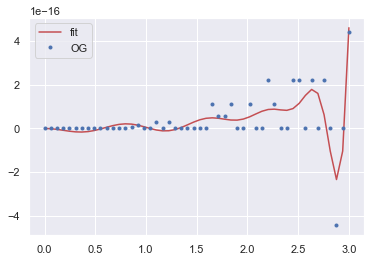

In [26]:
even_terms = (amp_sweep[2][:,100]+amp_sweep[2][:,0])/2
xdata = np.linspace(0,3,len(even_terms))



popt1, pcov1 = curve_fit(f = even, xdata=xdata , 
                       ydata = np.real(even_terms))



plt.plot(amp_sweep[1], even(amp_sweep[1], *popt1), 'r-', label="fit")
plt.plot(amp_sweep[1], even_terms, 'b.', label='OG')
plt.legend()



[0.16967376]


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


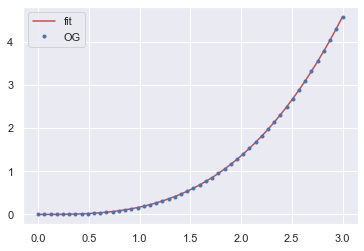

In [27]:
odd_terms = (amp_sweep[2][:,100]-amp_sweep[2][:,0])/2
xdata = np.linspace(0,3,len(odd_terms))



popt2, pcov2 = curve_fit(f = cube, xdata=xdata , 
                       ydata = np.real(odd_terms))



plt.plot(amp_sweep[1], cube(amp_sweep[1], *popt2), 'r-', label="fit")
plt.plot(amp_sweep[1], odd_terms, 'b.', label='OG')
plt.legend()

print(popt2)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(3.9889568178066164e-05+7.489968500780651e-20j)

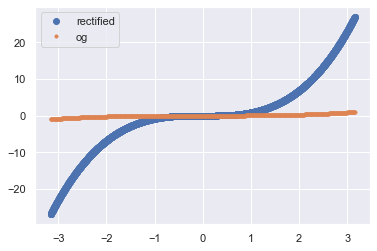

In [28]:
V_thz = (amp_sweep[0][2][100,:])
A0 = np.linspace(-3,3,2002)
A0_norm = A0/max(np.real(amp_sweep[0][2][100,:]))
t = np.linspace(-2,2,2002)
poopoo = np.linspace(-3/max(np.real(amp_sweep[0][2][100,:])),3/max(np.real(amp_sweep[0][2][100,:])),667)


a_n = popt2[0]/integrate.simps(V_thz**(3),x=t)

rec_current = a_n*A0**(3)
    
plt.plot(A0_norm, rec_current, 'o', label = "rectified")
#plt.plot(A0_norm,I.calculate(A0), label = 'OG')
plt.plot(poopoo, I.calculate(A0)[667:1334], '.',
         label = 'og')
plt.legend()
integrate.simps(y=V_thz,x=t)
